### MACHINE LEARNING FOR FINANCIAL MARKETS

TOPIC: IMPROVING TIME SERIES FORECASTING WITH SYNTHETIC DATA

Tools used: LSTM Neural Networks and GANs 

In [174]:
#Import all the necessary libraries for LSTM and GANs

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam #adam is the optimizer we are going to use
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


# PART 1: PREPARING THE DATASET

In [175]:
#load the dataset (data from 02/20/2015 to 02/19/2025)
path = '/Users/francescavasta/Desktop/MSFT historical data.csv'
df = pd.read_csv(path)

df

,Date,Close/Last,Volume,Open,High,Low
0,02/19/2025,$414.77,24114200,$407.88,$415.49,$407.65
1,02/18/2025,$409.64,21423050,$408.00,$410.597,$406.50
2,02/14/2025,$408.43,22758460,$407.79,$408.91,$405.88
3,02/13/2025,$410.54,23891730,$407.00,$411.00,$406.36
4,02/12/2025,$409.04,19121730,$407.21,$410.75,$404.3673
...,...,...,...,...,...,...
2510,02/26/2015,$44.055,26524300,$43.99,$44.23,$43.89
2511,02/25/2015,$43.99,29749090,$43.95,$44.09,$43.80
2512,02/24/2015,$44.09,25262080,$44.15,$44.30,$43.92
2513,02/23/2015,$44.15,32510550,$43.70,$44.19,$43.65


In [176]:
df = df[['Date', 'Close/Last']]
df.info()

#we see that we have a problem with the date format because it is a string
#also the stock value is a string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


In [177]:
#handling of ['Date'] values
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month = month, day=day)

#testing the function
#datetime_object = str_to_datetime('02/20/2015')
#datetime_object

df['Date'] = df['Date'].apply(str_to_datetime)
df

/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_11770/1503208539.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


,Date,Close/Last
0,2025-02-19,$414.77
1,2025-02-18,$409.64
2,2025-02-14,$408.43
3,2025-02-13,$410.54
4,2025-02-12,$409.04
...,...,...
2510,2015-02-26,$44.055
2511,2015-02-25,$43.99
2512,2015-02-24,$44.09
2513,2015-02-23,$44.15


In [178]:
#handling of Close/Last values
df["Close/Last"] = df["Close/Last"].str.replace(r"\$", "", regex=True) # to remove $
df["Close/Last"] = pd.to_numeric(df["Close/Last"], errors="coerce")
df['Close/Last'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_11770/1650891681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Close/Last"] = df["Close/Last"].str.replace(r"\$", "", regex=True) # to remove $
/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_11770/1650891681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Close/Last"] = pd.to_numeric(df["Close/Last"], errors="coerce")


In [179]:
#we prefer to have our data ordered chronologically from past to future 
df = df.sort_values(by="Date", ascending=True)
df = df.reset_index(drop=True)
df


,Date,Close/Last
0,2015-02-20,43.855
1,2015-02-23,44.150
2,2015-02-24,44.090
3,2015-02-25,43.990
4,2015-02-26,44.055
...,...,...
2510,2025-02-12,409.040
2511,2025-02-13,410.540
2512,2025-02-14,408.430
2513,2025-02-18,409.640


In [180]:
#now we want to remove the index and make the date itslef as the index
df.index = df.pop('Date')
df

,Close/Last
Date,
2015-02-20,43.855
2015-02-23,44.150
2015-02-24,44.090
2015-02-25,43.990
2015-02-26,44.055
...,...
2025-02-12,409.040
2025-02-13,410.540
2025-02-14,408.430


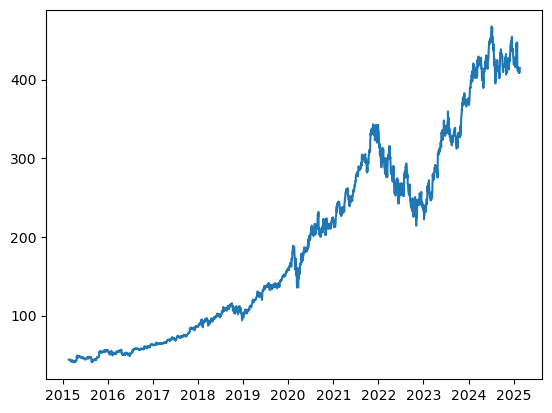

In [181]:
#plot the time series
plt.plot(df.index, df['Close/Last'])

In [182]:
#The function scrolls the DataFrame and creates time sequences (windows) of past data 
# to predict the future data (target).

def df_to_windowed_df (dataframe, first_date_str,last_date_str, n = 5): 
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X,Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date')
            return
    
        values = df_subset['Close/Last'].to_numpy()
        x, y = values [:-1], values [-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next date
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str=str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        # Find the next date
        #next_date = target_date + datetime.timedelta(days=1)  # Assuming the next day is the next target date
        
        #target_date = next_date

        if last_time: 
            break 

        target_date = next_date
        
        if target_date == last_date:
            last_time = True
        

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array (X)
    for i in range (0,n):
        X[:, i]
        ret_df[f'Target - {n-i}'] = X[:, i]
    
    ret_df['Target'] = Y 

    return ret_df    

In [183]:
#apply the function. The start date can't be 20/02/2015 because it must have 5 other dates prior
windowed_df = df_to_windowed_df(df,'02/27/2015', '02/19/2025' ,n = 5)

windowed_df

,Target Date,Target - 5,Target - 4,Target - 3,Target - 2,Target - 1,Target
0,2015-02-27,43.855,44.150,44.090,43.990,44.055,43.850
1,2015-03-02,44.150,44.090,43.990,44.055,43.850,43.880
2,2015-03-03,44.090,43.990,44.055,43.850,43.880,43.280
3,2015-03-04,43.990,44.055,43.850,43.880,43.280,43.055
4,2015-03-05,44.055,43.850,43.880,43.280,43.055,43.110
...,...,...,...,...,...,...,...
2505,2025-02-12,413.290,415.820,409.750,412.220,411.440,409.040
2506,2025-02-13,415.820,409.750,412.220,411.440,409.040,410.540
2507,2025-02-14,409.750,412.220,411.440,409.040,410.540,408.430
2508,2025-02-18,412.220,411.440,409.040,410.540,408.430,409.640


# PART 2: Preparing the data for Tensorflow and univariate forecasting and splitting into training, validation and test sets.

In [184]:
#this function helps us to distinguish the target variable from the predictors
def windowed_df_to_date_X_y (windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix  = df_as_np [:, 1:-1] #to take only the "Target-n" columns
    #middle matrix is not the final input matrix

    X = middle_matrix.reshape((len(dates),middle_matrix.shape[1], 1)) #"1" because it is univariate forecasting
    #if we used also the volume variable, then we would need to change the number

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X_orig, y_orig = windowed_df_to_date_X_y(windowed_df)

dates.shape, X_orig.shape, y_orig.shape

((2510,), (2510, 5, 1), (2510,))

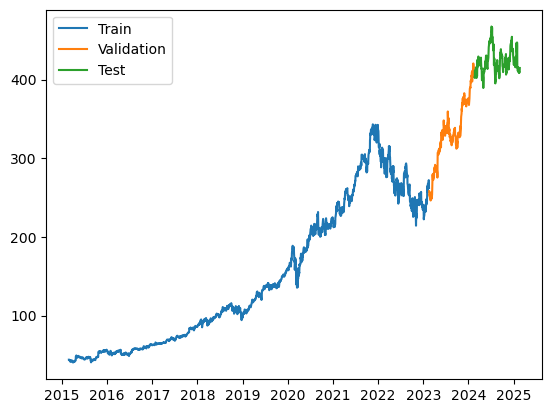

In [185]:
# Now we split the data and we also visualize the different sets on the graph
#with time series we can't do random splittings because the cronological order is important, so we use the quantiles

q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

dates_train, X_train_orig, y_train_orig = dates[:q_80], X_orig[:q_80], y_orig[:q_80]
dates_val, X_val_orig, y_val_orig = dates[q_80:q_90], X_orig[q_80:q_90], y_orig[q_80:q_90]
dates_test, X_test_orig, y_test_orig = dates[q_90:], X_orig[q_90:], y_orig[q_90:] #from q_90 onwards

plt.plot(dates_train, y_train_orig)
plt.plot(dates_val, y_val_orig)
plt.plot(dates_test, y_test_orig)

plt.legend(['Train', 'Validation', 'Test'])

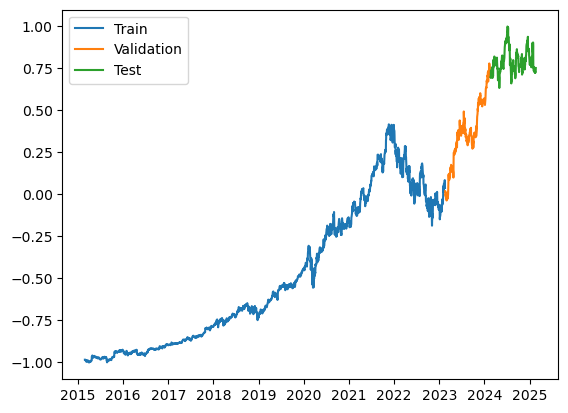

In [186]:
#LSTM performs better when using Standardized data 
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the data of "windowed_df"
windowed_df.iloc[:, 1:-1] = X_scaler.fit_transform(windowed_df.iloc[:, 1:-1])  # To standardize X
windowed_df.iloc[:, -1] = y_scaler.fit_transform(windowed_df.iloc[:, -1].values.reshape(-1, 1))  # To standardize y

# We need to apply again the function to obtain dates, X, y
dates, X_norm, y_norm = windowed_df_to_date_X_y(windowed_df)

# Now we split the data and we also visualize the different sets on the graph
#with time series we can't do random splittings because the cronological order is important, so we use the quantiles

q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

dates_train, X_train_norm, y_train_norm = dates[:q_80], X_norm[:q_80], y_norm[:q_80]
dates_val, X_val_norm, y_val_norm = dates[q_80:q_90], X_norm[q_80:q_90], y_norm[q_80:q_90]
dates_test, X_test_norm, y_test_norm = dates[q_90:], X_norm[q_90:], y_norm[q_90:] #from q_90 onwards

plt.plot(dates_train, y_train_norm)
plt.plot(dates_val, y_val_norm)
plt.plot(dates_test, y_test_norm)

plt.legend(['Train', 'Validation', 'Test'])

# PART 3: definition of the LSTM model

In [187]:
model = Sequential([layers.Input((5, 1)), # we need to specify the shape of the input
                    layers.LSTM(64), #the higher is this number, the higher is the risk of overfitting
                    layers.Dense(32, activation ='tanh'),
                    layers.Dense(32, activation ='tanh'),
                    layers.Dense(1) #by default the output is linear
                    ])

model.compile(loss= tf.keras.losses.Huber(delta=0.1), 
              optimizer=Adam(learning_rate=0.0001),
              metrics = ['mean_absolute_error'])

model.fit(X_train_norm,y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs = 100)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0434 - mean_absolute_error: 0.4820 - val_loss: 0.0295 - val_mean_absolute_error: 0.3445
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.1506 - val_loss: 0.0166 - val_mean_absolute_error: 0.2156
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0495 - val_loss: 0.0027 - val_mean_absolute_error: 0.0636
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1175e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0012 - val_mean_absolute_error: 0.0390
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8099e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0012 - val_mean_absolute_error: 0.0398
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9672e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0012 - val_mean_absolute_error: 0.0394
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9132e-04 - mean_absolute_error: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train Set Performance Metrics:
MAE: $2.25
RMSE: $3.58


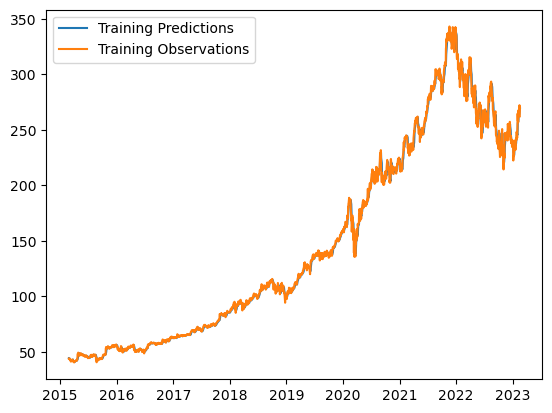

In [188]:
#the model was trained with X_train_norm and y_train_norm, now we use X_train_norm to make training predictions
#then we compare y_train (true) with train predictions
train_predictions_norm = model.predict(X_train_norm).flatten ()
#back to original scale with "inverse_transform" and reshape
train_predictions_orig = y_scaler.inverse_transform(train_predictions_norm.reshape(-1, 1)).flatten()


plt.plot (dates_train, train_predictions_orig) 
plt.plot (dates_train, y_train_orig)
plt. legend (['Training Predictions', 'Training Observations'])

#Performance on training set
mae_train = mean_absolute_error(y_train_orig, train_predictions_orig)
rmse_train = np.sqrt(mean_squared_error(y_train_orig, train_predictions_orig))
               
print("\nTrain Set Performance Metrics:")
print(f"MAE: ${mae_train:.2f}")
print(f"RMSE: ${rmse_train:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Validation Set Performance Metrics:
MAE: $5.48
RMSE: $6.84


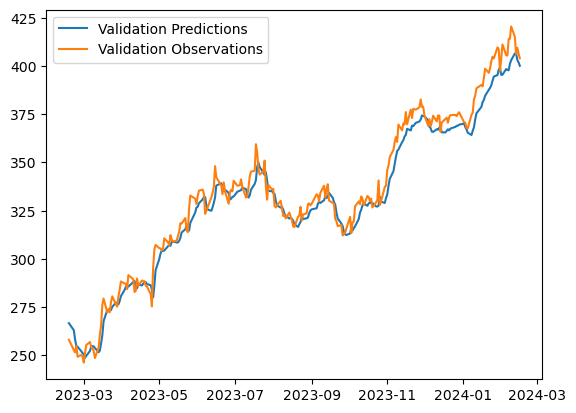

In [189]:
#Now we use X_val to try to predict y_val
val_predictions_norm = model.predict (X_val_norm).flatten () 
val_predictions_orig = y_scaler.inverse_transform(val_predictions_norm.reshape(-1, 1)).flatten()

plt.plot (dates_val, val_predictions_orig) 
plt.plot (dates_val, y_val_orig)
plt. legend(['Validation Predictions', 'Validation Observations'])

#Performance on validation set
mae_val = mean_absolute_error(y_val_orig, val_predictions_orig)
rmse_val = np.sqrt(mean_squared_error(y_val_orig, val_predictions_orig))

print("\nValidation Set Performance Metrics:")
print(f"MAE: ${mae_val:.2f}")
print(f"RMSE: ${rmse_val:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<>:17: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_11770/3743027223.py:17: SyntaxWarning: invalid escape sequence '\T'
  print("\Test Set Performance Metrics:")


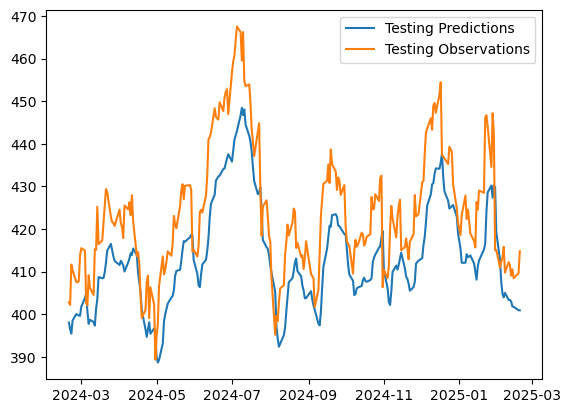

\Test Set Performance Metrics:
MAE: $10.96
RMSE: $12.31


In [190]:
#Finally we use the LSTM model to predict y_test, using X_test. 
#In other words, the model is now fit using data that the model has never seen before.

test_predictions_norm = model.predict(X_test_norm).flatten()
test_predictions_orig = y_scaler.inverse_transform(test_predictions_norm.reshape(-1, 1)).flatten()


plt.plot(dates_test, test_predictions_orig, label='Testing Predictions')
plt.plot(dates_test, y_test_orig, label='Testing Observations')
plt.legend()
plt.show()

#Performance on test set
mae_test = mean_absolute_error(y_test_orig, test_predictions_orig)
rmse_test = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig))

print("\Test Set Performance Metrics:")
print(f"MAE: ${mae_test:.2f}")
print(f"RMSE: ${rmse_test:.2f}")

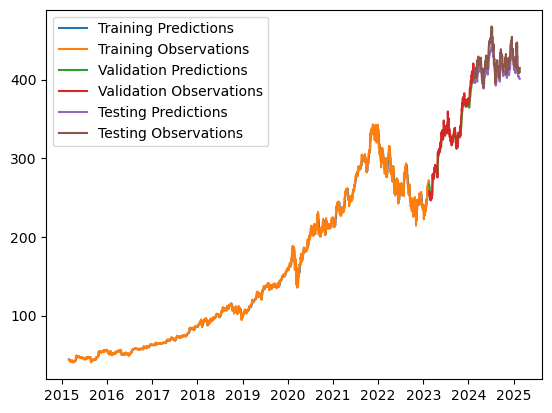

In [191]:
plt.plot (dates_train, train_predictions_orig) 
plt.plot (dates_train, y_train_orig) 
plt.plot (dates_val, val_predictions_orig) 
plt.plot (dates_val, y_val_orig) 
plt.plot (dates_test, test_predictions_orig) 
plt.plot (dates_test, y_test_orig) 
plt. legend(['Training Predictions', 
             'Training Observations',
             'Validation Predictions',
             'Validation Observations',
             'Testing Predictions',
             'Testing Observations'])

## it seems that the model is not good at extrapolating, which means predicting data out of its range!

The model struggles with extrapolation, meaning it has difficulty predicting values outside the range of the training data. Specifically, the training set 
(𝑋_train, 𝑦_train) is limited to values no higher than 350, whereas the latest observed data 
(𝑋_test, 𝑦_test) reach up to 460.

To address this, we could generate synthetic data to extend the range of the training set and improve the model's ability to generalize.


## GENERATIVE ADVERSIAL NETWORK

In [192]:
def build_generator(window_size):
    model = models.Sequential()
    model.add(layers.Input(shape=(window_size, 1)))  # Shape of the input (e.g., 5 time steps)
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(128, return_sequences=False))
    model.add(layers.Dense(window_size))  # Generate the same number of data points as the window size
    model.add(layers.Activation('tanh'))   # Cambia tanh con ReLU
    model.add(layers.Reshape((window_size, 1)))  # Add this to ensure the output is (batch_size, window_size, 1)
    return model

In [193]:
def build_discriminator(window_size):
    model = models.Sequential()
    model.add(layers.Input(shape=(window_size, 1)))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output a probability (real or fake)
    return model

In [194]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freezing the discriminator when training the GAN
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)  # Add the discriminator after the generator
    return model

In [195]:
discriminator = build_discriminator(window_size=5)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


generator = build_generator(window_size=5)
gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [196]:
# Ensure that layers can be trained
#generator.trainable = True
#discriminator.trainable = True

#for layer in generator.layers:
#    layer.trainable = True

#for layer in discriminator.layers:
#    layer.trainable = True

def train_gan(generator, discriminator, gan, real_data, epochs=1000, batch_size=64, window_size=5):
    half_batch = batch_size // 2
    
       # Liste per salvare le loss
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # Fase 1: Addestramento del discriminatore
        discriminator.trainable = True  # Abilita l'addestramento del discriminatore
        generator.trainable = True      # Il generatore deve rimanere trainable
        
        # Seleziona un batch casuale di dati reali
        idx = np.random.randint(0, real_data.shape[0], half_batch)
        real_data_batch = real_data[idx]
        
        # Genera un batch di dati falsi
        noise = np.random.normal(0, 1, (half_batch, window_size, 1))
        fake_data_batch = generator.predict(noise)
        
        # Addestra il discriminatore
        d_loss_real = discriminator.train_on_batch(real_data_batch, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data_batch, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Fase 2: Addestramento del generator attraverso il GAN stacked
        discriminator.trainable = False  # Blocca solo il discriminatore durante l'addestramento del generator
        
        noise = np.random.normal(0, 1, (batch_size, window_size, 1))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
    
        # Se d_loss è un array, estrai il valore scalare
        if isinstance(d_loss, np.ndarray):
            d_loss_value = d_loss[0]  # Prendi il valore scalare da d_loss
        else:
            d_loss_value = d_loss
        
        # g_loss dovrebbe essere già un valore scalare, quindi non fare nulla se non è un array
        g_loss_value = g_loss

        
        # Salva le loss
        d_losses.append(d_loss_value)
        g_losses.append(g_loss_value)
        
        # Stampa i risultati
        if epoch % 100 == 0:
            print(f'Epoch {epoch} [D loss: {d_loss_value:.4f}] [G loss: {g_loss_value:.4f}]')

    # Visualizza il grafico delle loss
    plt.figure(figsize=(10, 6))
    plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
    plt.plot(g_losses, label='Generator Loss', alpha=0.7)
    plt.title('GAN Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch 0 [D loss: 0.6901] [G loss: 0.6868]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━

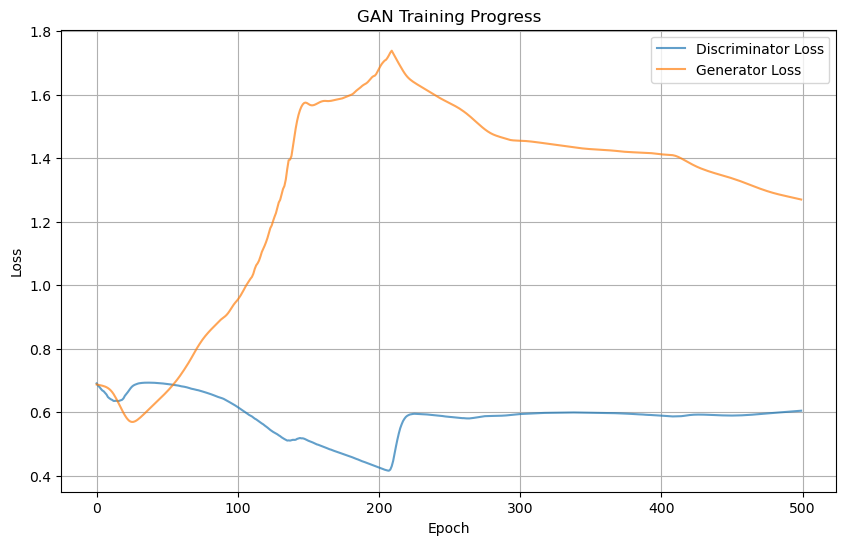

In [197]:
# Addestramento della GAN con i tuoi dati reali
train_gan(generator, discriminator, gan, X_train_norm, epochs=500, batch_size=64, window_size=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


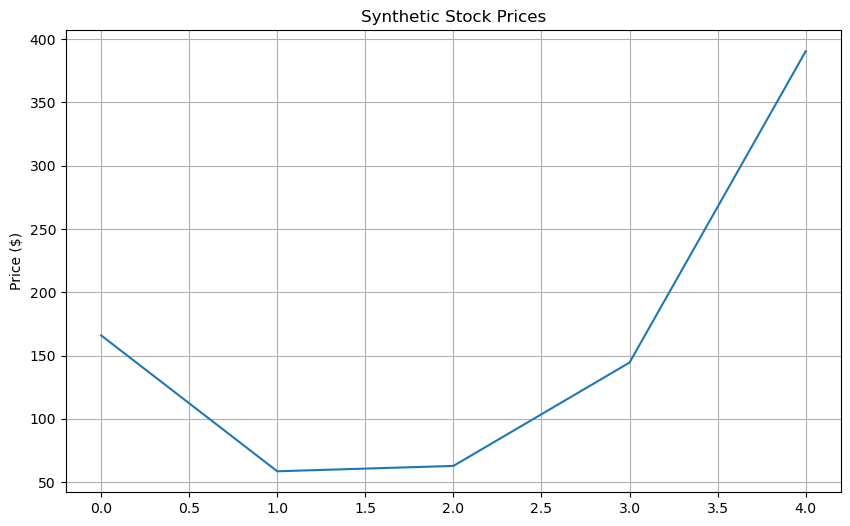

In [198]:
def generate_synthetic_data(generator, num_samples, window_size):
    noise = np.random.normal(0, 1, (num_samples, window_size, 1))
    generated_data = generator.predict(noise)
    
    # Reshape for de-normalization
    generated_data_reshaped = generated_data.reshape(-1, window_size) 
    generated_data_denorm = X_scaler.inverse_transform(generated_data_reshaped)
    
    return generated_data_denorm.reshape(num_samples, window_size, 1)

# Genera e visualizza i dati
generated_data = generate_synthetic_data(generator, 10, 5)
plt.figure(figsize=(10, 6))
plt.plot(generated_data[0])
plt.title("Synthetic Stock Prices")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


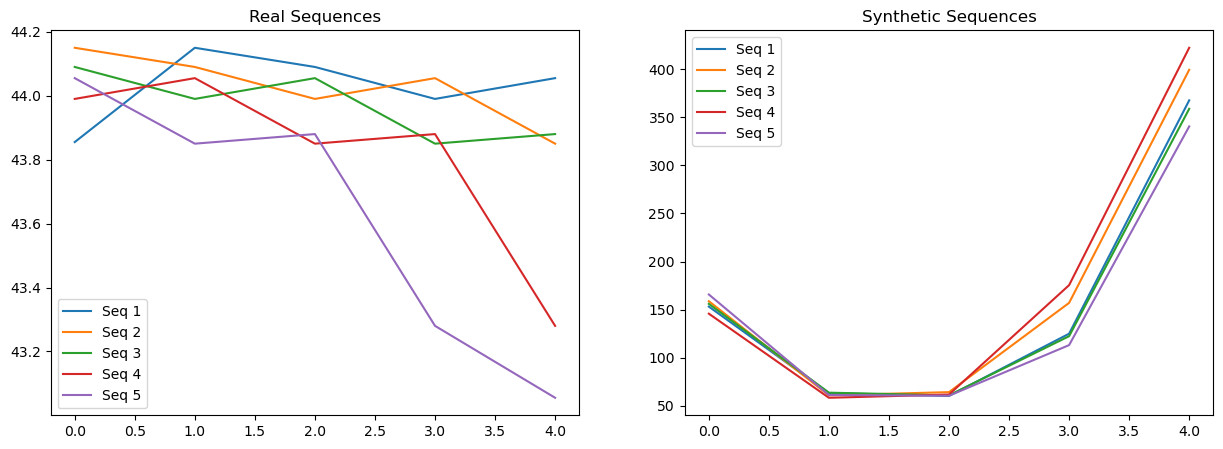

In [205]:
# 1. Generate syntehtic data using 50% of X_train
num_synthetic = int(X_train_norm.shape[0] * 0.5)  # Genera 50% di dati sintetici
synthetic_sequences = generate_synthetic_data(generator, num_synthetic, 5)
# Usa il modello LSTM originale per generare i target
synthetic_targets = model.predict(synthetic_sequences) 

# 2. Visualizza confronto tra sequenze reali e sintetiche
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(X_train_orig[i, :, 0], label=f'Seq {i+1}')
plt.title('Real Sequences')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(synthetic_sequences[i, :, 0], label=f'Seq {i+1}')
plt.title('Synthetic Sequences')
plt.legend()
plt.show()


In [206]:
# 3. Combina i dati reali e sintetici
X_train_augmented = np.concatenate([X_train_norm, synthetic_sequences], axis=0)
y_train_augmented = np.concatenate([y_train_norm, synthetic_targets.flatten()], axis=0)



# 4. Shuffle i dati (opzionale)
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

X_train_augmented
y_train_augmented


array([ 0.28574437, -0.1774756 ,  2.6782105 , ...,  2.6731658 ,
       -0.71652585, -0.35258734], dtype=float32)

In [207]:
# 5. Riaddestra l'LSTM con i dati aumentati
model_augmented = Sequential([
    layers.Input((5, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)
])

model_augmented.compile(
    loss=tf.keras.losses.Huber(delta=0.1),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mean_absolute_error']
)

# Addestra il modello con i dati aumentati
history_augmented = model_augmented.fit(
    X_train_augmented, 
    y_train_augmented,
    validation_data=(X_val_norm, y_val_norm),
    epochs=100
)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0779 - mean_absolute_error: 0.8272 - val_loss: 0.0207 - val_mean_absolute_error: 0.2571
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0516 - val_loss: 0.0020 - val_mean_absolute_error: 0.0535
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6785e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0010 - val_mean_absolute_error: 0.0359
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3711e-04 - mean_absolute_error: 0.0093 - val_loss: 9.2937e-04 - val_mean_absolute_error: 0.0342
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4510e-04 - mean_absolute_error: 0.0096 - val_loss: 9.4139e-04 - val_mean_absolute_error: 0.0345
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2689e-04 - mean_absolute_error: 0.0089 - val_loss: 0.0010 - val_mean_absolute_error: 0.0359
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4176e-04 - mean_absol

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


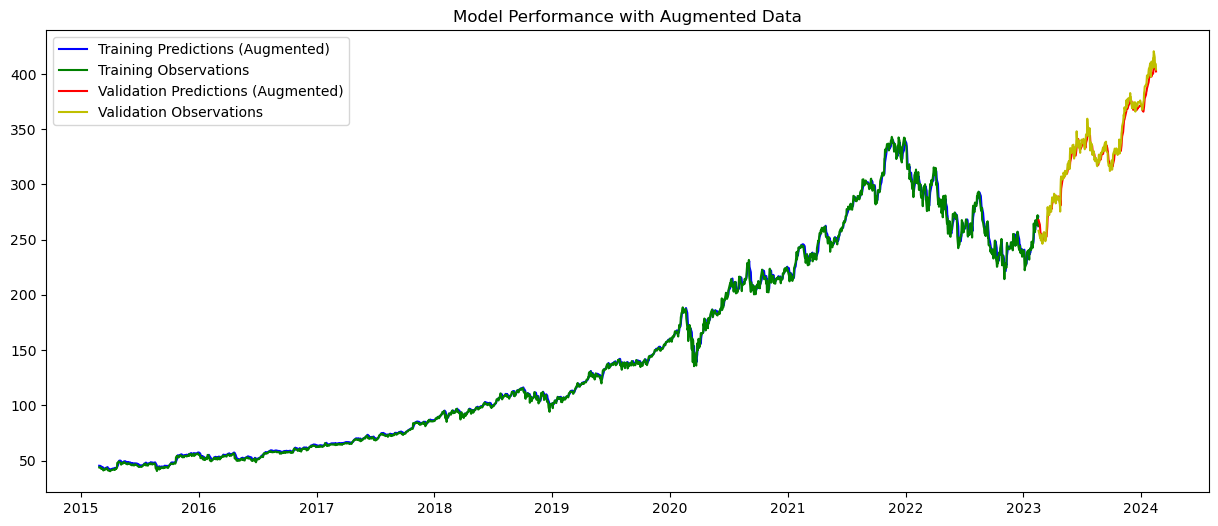

In [208]:
# Check the performance of the LSTM model with AUGMENTED DATA
train_predictions_aug_norm = model_augmented.predict(X_train_norm)
val_predictions_aug_norm = model_augmented.predict(X_val_norm)


train_predictions__aug_orig = y_scaler.inverse_transform(train_predictions_aug_norm.reshape(-1, 1))
val__predictions__aug_orig = y_scaler.inverse_transform(val_predictions_aug_norm.reshape(-1, 1))

# Plot dei risultati
plt.figure(figsize=(15, 6))
plt.plot(dates_train, train_predictions__aug_orig, 'b', label='Training Predictions (Augmented)')
plt.plot(dates_train, y_train_orig, 'g', label='Training Observations')
plt.plot(dates_val, val__predictions__aug_orig, 'r', label='Validation Predictions (Augmented)')
plt.plot(dates_val, y_val_orig, 'y', label='Validation Observations')
plt.legend()
plt.title('Model Performance with Augmented Data')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


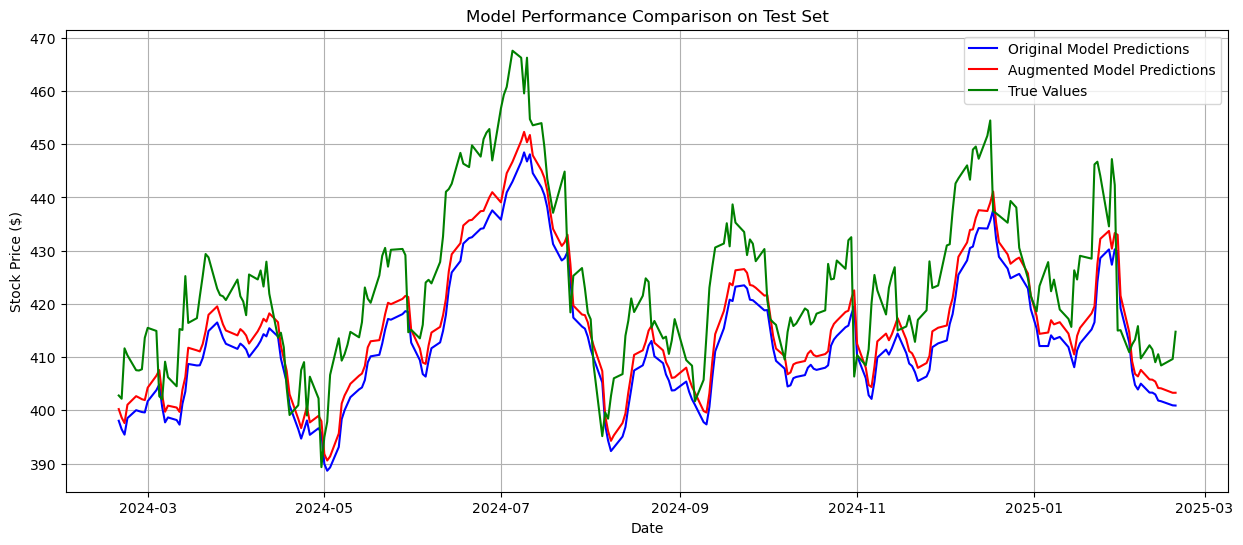

In [209]:
# 1. Fai le predizioni sul test set usando entrambi i modelli
test_predictions_norm = model.predict(X_test_norm)  # modello originale
test_predictions_aug_norm = model_augmented.predict(X_test_norm) # modello con dati aumentati

test_predictions_orig = y_scaler.inverse_transform(test_predictions_norm.reshape(-1, 1))
test_predictions__aug_orig = y_scaler.inverse_transform(test_predictions_aug_norm.reshape(-1, 1))

# 2. Plot di confronto
plt.figure(figsize=(15, 6))
plt.plot(dates_test, test_predictions_orig, 'b', label='Original Model Predictions')
plt.plot(dates_test, test_predictions__aug_orig, 'r', label='Augmented Model Predictions')
plt.plot(dates_test, y_test_orig, 'g', label='True Values')
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [210]:

# Per il modello originale
mae_original = mean_absolute_error(y_test_orig, test_predictions_orig)
rmse_original = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig))

# Per il modello con dati aumentati
mae_augmented = mean_absolute_error(y_test_orig, test_predictions__aug_orig)
rmse_augmented = np.sqrt(mean_squared_error(y_test_orig, test_predictions__aug_orig))

print("\nTest Set Performance Metrics:")
print("\nOriginal Model:")
print(f"MAE: ${mae_original:.2f}")
print(f"RMSE: ${rmse_original:.2f}")

print("\nAugmented Model:")
print(f"MAE: ${mae_augmented:.2f}")
print(f"RMSE: ${rmse_augmented:.2f}")

# 4. Calcola la percentuale di miglioramento
mae_improvement = ((mae_original - mae_augmented) / mae_original) * 100
rmse_improvement = ((rmse_original - rmse_augmented) / rmse_original) * 100

print(f"\nImprovement with Data Augmentation:")
print(f"MAE Improvement: {mae_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")


Test Set Performance Metrics:

Original Model:
MAE: $10.96
RMSE: $12.31

Augmented Model:
MAE: $8.65
RMSE: $10.02

Improvement with Data Augmentation:
MAE Improvement: 21.06%
RMSE Improvement: 18.60%
